# SVM

**Classification**

Prerequisite：Linearly separable

Basic idea is Max Margin Classifier, we have to find the widest road between class1 and class2.

\begin{align}
max:margin(w,b)
\\st.
\left\{\begin{matrix}
w^Tx_i +b>0,y_i=+1\\ 
w^Tx_i +b<0,y_i=-1
\end{matrix}\right.
\\
 \Rightarrow y_i(w^{T}x_{i}+b) > 0\\
 \forall i=1,2,...,N
\end{align}

1. For the hard margin:

   * We set margin equals 1, and $y_i(w^Tx_i+b)\geqslant1$;
    
2. For the soft margin:

   * We allow some noise, so that we can increase the robustness of our system. 
   
   * We introduced slckness variable $\xi$, which represent **loss**. 
   
   * And now the margin function changes to $y_i(w^Tx_i+b)\geqslant1-\xi_i,s.t.xi\geqslant0$




Suppose we have two classes X and O, for class X:

   1. When X is correctly classified, means X locates outside the margin, then $\xi=0$
   2. WHen X is incorrecly classified and locates on the right side of $y_i(w^Tx_i+b)\geqslant0$,then $0<\xi\leqslant0$ 
   3. When X is on the other side of margin, which means $y_i(w^Tx_i+b)\leqslant0$, then $\xi>1$
   
Based on these 3 conditions, we get the new target funtion:

\begin{align}
min_{w,b,\xi }:\frac{1}{2}\left \| w \right \|^{2}+C\sum_{i=1}^{N}\xi_i\\
s.t. \left\{\begin{matrix}y_i(w^Tx_i + b)\geqslant 1-\xi_i
\\ \xi_i\geqslant0\\
\end{matrix}\right.
\\
\end{align}

The loss function here called **Hinge Loss**, basically it uses distance to measure **loss**: $\xi$ represents the distance from a point to its corresponding margin $w^Tx+b=1$ when it is miss-classified.

   1. If $w^Tx+b\geqslant1$, $\xi_i=0$, No loss, correct.
   2. If $w^Tx+b<1$, $\xi_i=1-y_i(w^Tx+b)$
   
So now we have:
   \begin{align}
\xi_i =max\left \{ 0,1-y_i(w^Tx_i + b) \right \}
\end{align}
   

Base on lagrange duality and KKT conditions, now we get the new target:



\begin{align}
min: \sum_{i=1}^{N}\alpha_i - \frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}\alpha_i\alpha_jy_iy_jX_i^TX_j\\
s.t.  \left\{\begin{matrix}
0< \alpha_i<C\\
\sum_{i=1}^{N}\alpha_iy_i=0
\end{matrix}\right.
\\
\end{align}


Optimal Solutions:

$W^* = \sum_{i=1}^{N}x_iy_i\alpha_i$

$b^* = y_i-w^Tx_i$



#### SMO: Sequential Minimal Optimization

Basic idea: SGD and paired $\alpha$

Each time, we only update tow $\alpha$s, the rest of them were treated as constant **Const**.

Now set:

1. $K_{ij} = X_i^TX_j$
2. $f(x_k)=\sum_{i=1}^{N}\alpha_iy_iX_i^Tx_k+b$
3. Error: $E_i = f(x_i)-y_i$
4. $\xi=K_{mm}+K_{nn}-2K_{mn}$

Then we get:

1. $\alpha_2^{new} = \alpha_2^{old} + y_2\frac{(E_1-E_2)}{\xi}$
2. $\alpha_1^{new}=\alpha_1^{old}+y_1y_2(\alpha_2^{old}-\alpha_2^{new})$


In [1156]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix

In [1157]:
# input data: feature and target should be in matrix form
# data_mat, label_mat

In [1158]:
# define a function to randomly choose a paired alpha j
def select_rand_j(i,maximun_number):
    # i is the input index of alpha, and we need to find a j that is different from i
    # maximun_number is the maximun # of samples or rows
    j = i
    while j==i:
        j = int(random.uniform(0,maximun_number))
    return j


Based on KKT condition, $\sum_{i=1}^{N}\alpha_iy_i=0$, and each time we only update two $\alpha$

we have $\alpha_1y_1 + \alpha_2y_2 + \sum_{i=3}^{N}\alpha_iy_i = 0$

and $\alpha_1^{new}y_1 + \alpha_2^{new}y_2 = \alpha_1^{old}y_1 + \alpha_2^{old}y_2 = Constant K$

So, for each pair of $\alpha$, there are upper and lower limits for them

In [1159]:
def clip_alpha(alpha, H, L):
    if alpha > H:
        alpha = H
    elif alpha < L:
        alpha = L
    return alpha

In [1160]:
def feature_scale(df):
    # Normalization
    m,n = np.shape(df)
    for i in range(n):
        X_min = np.min(df.iloc[:,i])
        X_max = np.max(df.iloc[:,i])
        if X_max-X_min == 0:
            df.iloc[:,i] = df.iloc[:,i]
        else:
            df.iloc[:,i] = (df.iloc[:,i] - X_min)/(X_max-X_min)
    return df

In [1246]:
class svc():
    def __init__(self,data_mat,label_mat,C,tolerance,iteration,kernel):
        self.C = 0.6
        self.data_mat = data_mat
        self.label_mat = label_mat
        self.tolerance = 0.001
        self.iteration = 10
        self.kernel = kernel
    
    # feature scaling

        
    # now define smo function
    def smo_simple(self):
        # data_mat: feature matrix m*n
        # label_mat: label matrix m*1
        #label_mat = self.X.copy()
        label_mat[label_mat==0]=-1
        # C: hyperparameter
        b = 0
        m, n = np.shape(self.data_mat)
        alpha = np.asmatrix(np.zeros((m,1)))
        iter = 0
        while iter < self.iteration:
            # randomly choose an alpha i
            # i = rand,uniform(0,m)
            alpha_pairs_changed = 0
            for i in range(m):
                wT = np.dot(np.multiply(alpha,self.label_mat).T,self.data_mat)
                f_xi = np.dot(wT,self.data_mat[i,:].T) + b
                E_i = f_xi - float(self.label_mat[i])
                # if the error is less than tolerance, we stop.
                # if E_i * y_i > tolerance, this point locates on the right side
                # if E_i * y_i < tolerance, this point locates on the wrong side, and alpha needs to be updated
                if ((E_i * self.label_mat[i,:] < -self.tolerance) and (alpha[i]<self.C)) or \
                (( E_i * self.label_mat[i] > self.tolerance) and (alpha[i] > 0)): 
                    ####?????????????????????????????????
                    # Now we need find its paired alpha j
                    j = select_rand_j(i,m)
                    f_xj = float(np.dot(wT,self.data_mat[j,:].T)) + b
                    E_j = f_xj - float(self.label_mat[j])
                    alpha_j_old = alpha[j].copy()
                    alpha_i_old = alpha[i].copy()
                    #print('now {}{}{}{}'.format(E_i,E_j,alpha_i_old,alpha_j_old))
                    
                    # 
                    if (self.label_mat[i] != self.label_mat[j]):
                        # alpha1 - alpha2 = Constant
                        # alpha1 = C - alpha2
                        # 0 < alpha < C
                        L = max(0,alpha[j] - alpha[i])
                        H = min(self.C ,self.C + alpha[j] - alpha[i])
                    else:
                        # alpha1+alpha2 = constant
                        L = max(0,alpha[j] + alpha[i] - self.C) 
                        H = min(self.C, alpha[j] + alpha[i])
                    if L==H:
                        
                        continue
                    #print('L{}'.format(L))
                    #print('H{}'.format(H))
                    
                    
                    # 𝜉=𝐾𝑚𝑚+𝐾𝑛𝑛−2𝐾𝑚𝑛
#                     eta = np.dot(self.data_mat[i,:],self.data_mat[i,:].T) + np.dot(self.data_mat[j,:],self.data_mat[j,:].T) -\
#                     2.0 * np.dot(self.data_mat[i,:],self.data_mat[j,:].T)
                    eta = -np.dot(self.data_mat[i,:],self.data_mat[i,:].T) - np.dot(self.data_mat[j,:],self.data_mat[j,:].T) +\
                    2.0 * np.dot(self.data_mat[i,:],self.data_mat[j,:].T)
                    if eta >= 0:
                        #print('eta')
                        continue
                    #print('eat{}'.format(eta))
                    alpha[j] = alpha[j] - self.label_mat[j]*(E_i-E_j)/eta
                    #print('alpha{},label{}'.format(alpha[j],label_mat[j]))
                    alpha[j] = clip_alpha(alpha[j],H,L)
                    #print(alpha[j])
                    
                    if (abs(alpha[j] - alpha_j_old) < 0.00001): #self.tolerance
                        #print('tolerance')
                        continue

                    #𝛼𝑛𝑒𝑤1=𝛼𝑜𝑙𝑑1+𝑦1𝑦2(𝛼𝑜𝑙𝑑2−𝛼𝑛𝑒𝑤2)
                    alpha[i] = alpha[i] + self.label_mat[i]*self.label_mat[j]*(alpha_j_old-alpha[j])


                    # calculate b

                    b1_new = b - E_i - self.label_mat[i]*(alpha[i] - alpha_i_old)*np.dot(self.data_mat[i,:],self.data_mat[i,:].T)\
                                - self.label_mat[j]*(alpha[j]-alpha_j_old)*np.dot(self.data_mat[i,:],self.data_mat[j,:].T)
                    b2_new = b - E_j - self.label_mat[i]*(alpha[i] - alpha_i_old)*np.dot(self.data_mat[i,:],self.data_mat[j,:].T)\
                                - self.label_mat[j]*(alpha[j]-alpha_j_old)*np.dot(self.data_mat[j,:],self.data_mat[j,:].T)
                    if (0 < alpha[i]) and (alpha[i] < self.C):
                        b = b1_new
                    elif (0 < alpha[j]) and (alpha[j]< self.C):
                        b = b2_new
                    else:
                        b = (b1_new + b2_new)/2.0
                    #print(b)
                    alpha_pairs_changed += 1
                
            if (alpha_pairs_changed == 0): iter += 1
            else: iter = 0
            
        return b, alpha


In [1247]:
df = pd.read_csv('ex.csv')
# feature_scale(df.drop('target',axis=1))


In [1248]:
feature = feature_scale(df.drop('target',axis=1))
target = df['target'].to_frame()
df = pd.concat([feature,target],axis=1)


In [1249]:

feature = feature.to_numpy()
data_mat = np.asmatrix(feature)
target = target.to_numpy()
label_mat = np.asmatrix(target)


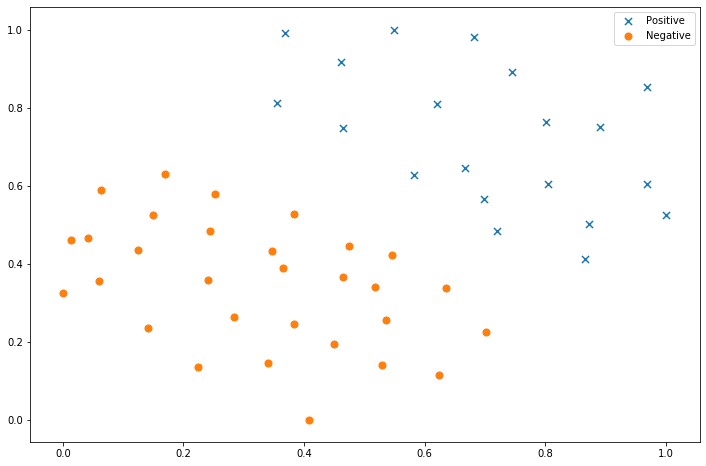

In [1250]:
 
positive = df[df['target'].isin([1])]
negative = df[df['target'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['f1'], positive['f2'], s=50, marker='x', label='Positive')
ax.scatter(negative['f1'], negative['f2'], s=50, marker='o', label='Negative')
ax.legend()
plt.show()




In [1251]:
X = data_mat
y = label_mat
svm = svc(X,y, C = 0.6, tolerance = 0.001,iteration = 10,kernel= 'RBF')

In [1252]:
b, alphas = svm.smo_simple()

In [1253]:
w_opt = np.dot(np.multiply(alphas,label_mat).T,data_mat)

In [1254]:
prediction = data_mat * w_opt.T + b
def sign(x):
    ls=[]
    for i in range(len(x)):
        if x[i] >= 0:
            ls.append(1)
        else:
            ls.append(0)
    return ls
pred = sign(prediction[:,0])

In [1255]:
b = b[0,0]
w = w_opt

m = np.linspace(0,1)

n = (-b - w[0,0]*m)/w[0,1]

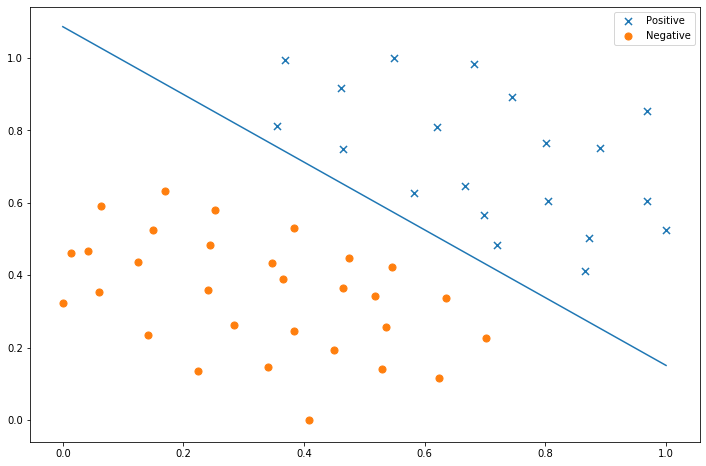

In [1256]:

positive = df[df['target'].isin([1])]
negative = df[df['target'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['f1'], positive['f2'], s=50, marker='x', label='Positive')
ax.scatter(negative['f1'], negative['f2'], s=50, marker='o', label='Negative')
ax.plot(m,n)
ax.legend()
plt.show()



In [1257]:
s = LinearSVC()

In [1258]:
s.fit(X= df.drop('target',axis=1), y=df['target'].to_frame())

/Users/qijin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [1259]:
b = s.intercept_[0]
w = s.coef_[0]

x = np.linspace(0,1)

y = (-b - w[0]*x)/w[1]

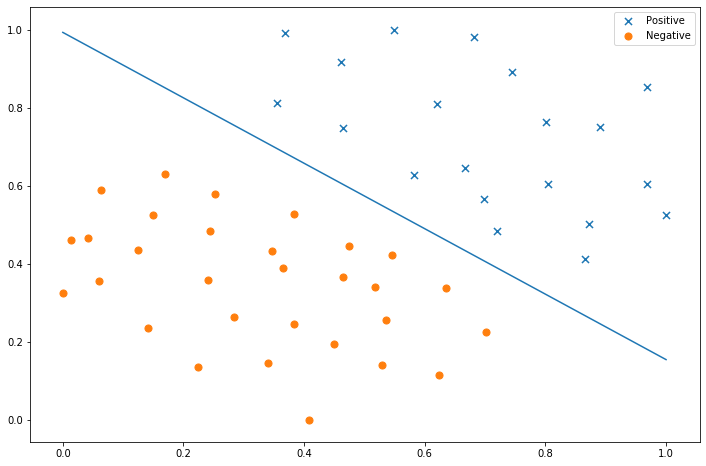

In [1260]:

 
positive = df[df['target'].isin([1])]
negative = df[df['target'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['f1'], positive['f2'], s=50, marker='x', label='Positive')
ax.scatter(negative['f1'], negative['f2'], s=50, marker='o', label='Negative')
ax.plot(x,y)
ax.legend()
plt.show()



In [1261]:
from sklearn import datasets
iris = datasets.load_iris()

feature = pd.DataFrame(iris.data,columns=iris.feature_names)
target = pd.DataFrame(iris.target,columns=['target'])
df = pd.concat([feature,target],axis=1)
df = df[df['target']!=2]

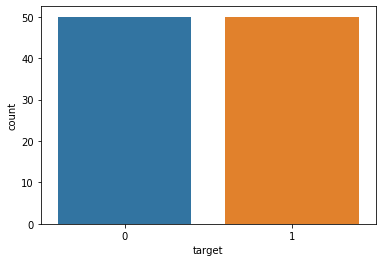

In [1262]:
sns.countplot(df['target'])

In [1263]:
df =df.reset_index()
target = df['target'].to_frame()
feature = df.drop('target',axis=1)
type(feature)

pandas.core.frame.DataFrame

In [1264]:
feature = feature.to_numpy()
data_mat = np.asmatrix(feature)
target = target.to_numpy()
label_mat = np.asmatrix(target)



In [1265]:
svm = svc(data_mat = data_mat,label_mat = label_mat, C = 0.6, tolerance = 0.001,iteration = 10,kernel= 'RBF')

In [1266]:
b,alphas = svm.smo_simple()
w_opt = np.dot(np.multiply(alphas,label_mat).T,data_mat)

In [1267]:
from sklearn.metrics import confusion_matrix

In [1268]:
prediction = data_mat * w_opt.T + b
def sign(x):
    ls=[]
    for i in range(len(x)):
        if x[i] >= 0:
            ls.append(1)
        else:
            ls.append(0)
    return ls
pred = sign(prediction[:,0])

In [1270]:
label_mat[label_mat==-1]=0
np.array(label_mat.T)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [1271]:
np.array(pred)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [1272]:
confusion_matrix(label_mat,pred)

array([[50,  0],
       [ 0, 50]])